# Preprocessing and Environment Setup

In [1]:
!git clone https://github.com/oshanyalegama/RAD_assignment.git

Cloning into 'RAD_assignment'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (179/179), done.
Receiving objects: 100% (179/179), 961.27 KiB | 15.26 MiB/s, done.
remote: Total 179 (delta 69), reused 0 (delta 0), pack-reused 0 (from 0)
Resolving deltas: 100% (69/69), done.


## Updating repository and getting to directory

In [2]:
import os
os.chdir("/kaggle/working/RAD_assignment")

In [3]:
!git pull

Already up to date.


## Loading YOLOv5 S from Torch Hub

In [4]:
import torch
model = torch.hub.load("ultralytics/yolov5", "yolov5s", _verbose=False, classes = 2)  # load silently

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
from PIL import Image
import torch
from torchvision import transforms

# Load an image using PIL
image = Image.open('/kaggle/input/dog-and-cat-detection/images/Cats_Test0.png')

print(image.size)
# Define a transformation to convert the image to a tensor and normalize it (optional)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size (e.g., for ResNet)
    transforms.ToTensor(),          # Convert image to tensor
])

# Apply the transformation to the image
image_tensor = transform(image)

# Add a batch dimension (since models expect a batch of images)
image_tensor = image_tensor.unsqueeze(0)

(233, 350)


## Dataloader Preparation

In [6]:
os.chdir("/kaggle/working/")

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import xml.etree.ElementTree as ET
import os

import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision import transforms


import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import random


class XAMLAnnotationDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform=None, num_classes=2, max_per_class=100):
        """
        Args:
            img_dir (str): Directory with all the images.
            annotation_dir (str): Directory with all the XAML annotation files.
            transform (callable, optional): Optional transform to be applied on a sample.
            num_classes (int): Number of classes.
            max_per_class (int): Maximum number of images per class to include in the dataset.
        """
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.num_classes = num_classes
        self.max_per_class = max_per_class
        
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]  # Assuming image files are .jpg or .png
        self.annotation_names = [f.replace('.jpg', '.xml').replace('.png', '.xml') for f in self.img_names]
        
        # Filter images to include only 50 cat and 50 dog images
        self.filtered_img_names = []
        self.filtered_annotation_names = []
        
        # Get the first 50 images for each class
        class_counts = {'cat': 0, 'dog': 0}
        
        for img_name, annotation_name in zip(self.img_names, self.annotation_names):
            annotation_path = os.path.join(self.annotation_dir, annotation_name)
            targets = self.parse_xaml(annotation_path, 0)  # parse the annotation to get targets

            for target in targets:
                class_idx = target[1]  # class index
                class_name = 'cat' if class_idx == 0 else 'dog'

                if class_counts[class_name] < self.max_per_class:
                    self.filtered_img_names.append(img_name)
                    self.filtered_annotation_names.append(annotation_name)
                    class_counts[class_name] += 1
                    break  # Only take one class per image

        # Ensure we have the correct number of images for each class
        assert class_counts['cat'] == self.max_per_class, "Not enough cat images"
        assert class_counts['dog'] == self.max_per_class, "Not enough dog images"

    def parse_xaml(self, annotation_file, img_idx):
        """
        Parse the XAML annotation file to extract bounding boxes and class labels.
        Converts the bounding box to [x_center, y_center, width, height] scaled to target image size.
        Adds a unique image index to each target.
        """
        TARGET_WIDTH = 224
        TARGET_HEIGHT = 224
    
        tree = ET.parse(annotation_file)
        root = tree.getroot()
    
        targets = []
        orig_width = int(root.find('size/width').text)
        orig_height = int(root.find('size/height').text)
    
        scale_x = TARGET_WIDTH / orig_width
        scale_y = TARGET_HEIGHT / orig_height
    
        for obj in root.iter('object'):
            class_name = obj.find('name').text
            class_idx = self.class_to_idx(class_name)
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
    
            # Scale coordinates
            xmin *= scale_x
            xmax *= scale_x
            ymin *= scale_y
            ymax *= scale_y
    
            # Convert to [x_center, y_center, width, height]
            x_center = (xmin + xmax) / 2
            y_center = (ymin + ymax) / 2
            width = xmax - xmin
            height = ymax - ymin
    
            # Normalize by target image size (224)
            x_center /= TARGET_WIDTH
            y_center /= TARGET_HEIGHT
            width /= TARGET_WIDTH
            height /= TARGET_HEIGHT
    
            targets.append([img_idx, class_idx, x_center, y_center, width, height])
    
        return targets

    def class_to_idx(self, class_name):
        """
        Convert class name to index (for multi-class classification).
        Assumes classes are indexed from 0.
        """
        class_map = {'cat': 0, 'dog': 1}  # Example mapping
        return class_map.get(class_name, -1)  # Default to -1 if class not found

    def __getitem__(self, idx):
        """
        Load an image and its annotation.
        """
        img_name = self.filtered_img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert('RGB')

        annotation_name = self.filtered_annotation_names[idx]
        annotation_path = os.path.join(self.annotation_dir, annotation_name)

        # Parse the annotation and add the image index to targets
        targets = self.parse_xaml(annotation_path, idx)

        # Convert targets to tensor
        targets = torch.tensor(targets)

        # Apply transforms if any
        if self.transform:
            img = self.transform(img)
        width, height = img.shape[2], img.shape[1]
        img_size = (width, height)

        return img, targets, img_path, img_size

    def __len__(self):
        return len(self.filtered_img_names)

    @staticmethod
    def collate_fn(batch):
        """Batches images, labels, paths, and shapes, assigning unique indices to targets in merged label tensor."""
        im, label, path, shapes = zip(*batch)  # transposed
        for i, lb in enumerate(label):
            lb[:, 0] = i  # add target image index for build_targets()
        return torch.stack(im, 0), torch.cat(label, 0), path, shapes


def create_val_loader(train_loader, val_split=0.2):
    # Get the indices of the entire train dataset
    dataset_size = len(train_loader.dataset)
    indices = list(range(dataset_size))

    # Shuffle indices to get random samples for validation
    random.shuffle(indices)

    # Split the indices into training and validation sets
    val_size = int(dataset_size * val_split)
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]

    # Create the subsets for train and validation
    train_subset = Subset(train_loader.dataset, train_indices)
    val_subset = Subset(train_loader.dataset, val_indices)

    # Create new DataLoaders for training and validation
    train_loader = DataLoader(train_subset, batch_size=train_loader.batch_size, collate_fn=train_loader.collate_fn)
    val_loader = DataLoader(val_subset, batch_size=train_loader.batch_size, collate_fn=train_loader.collate_fn)

    return train_loader, val_loader
    
# Resizing to (224, 224)
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert image to tensor
])

# Define dataset and dataloader
img_dir = '/kaggle/input/dog-and-cat-detection/images'
annotation_dir = '/kaggle/input/dog-and-cat-detection/annotations'
dataset = XAMLAnnotationDataset(img_dir=img_dir, annotation_dir=annotation_dir, transform=transform)

train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=XAMLAnnotationDataset.collate_fn)

train_loader, val_loader = create_val_loader(train_loader, val_split=0.2)

# # Example to test:
# for imgs, targets, paths, shapes in train_loader:
#     print(imgs.shape)  # Shape of the first image in the batch
#     print(targets[0])  # First target in the batch
#     print(paths[0])  # Path of the first image in the batch
#     print(shapes)  # Shape of the first image in the batch
#     break


## Selecting Loss Function and Loading Optimizer

In [8]:
from RAD_assignment.utils.loss import ComputeLoss, ComputeNewLoss

# criterion = ComputeLoss(model) # using only IOU (other than BCE and objectness)
criterion = ComputeNewLoss(model) # new loss function including other metrics

In [9]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Example optimizer; modify as neede

## Selecting Device (Default will be cuda if cuda is available)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training Loop 

In [11]:
from tqdm import tqdm

# Training loop
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    # Use tqdm to show progress for each batch
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs}") as tepoch:
        for inputs, targets, _,_ in tepoch:
            # Assuming each element in the batch is a tuple (input, target)
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            inputs = inputs.float()  # uint8 to fp16/32
            inputs /= 255  # 0 - 255 to 0.0 - 1.0
            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss, y = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track the loss
            running_loss += loss.item()

            # Update tqdm description with the current loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')
    
    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(val_loader, unit="batch", desc=f"[Val] Epoch {epoch+1}/{num_epochs}") as vepoch:
            for inputs, targets, _, _ in vepoch:
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = inputs.float() / 255.0  # Normalize

                _, outputs = model(inputs)
                loss, y = criterion(outputs, targets)
                val_loss += loss.item()
                vepoch.set_postfix(val_loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

Epoch 1/30: 100%|██████████| 10/10 [00:06<00:00,  1.43batch/s, loss=15.1]


Epoch [1/30], Training Loss: 17.4562


[Val] Epoch 1/30: 100%|██████████| 3/3 [00:00<00:00,  3.22batch/s, val_loss=16.1]


Epoch [1/30], Validation Loss: 26.5404


Epoch 2/30: 100%|██████████| 10/10 [00:02<00:00,  4.32batch/s, loss=10.7]


Epoch [2/30], Training Loss: 11.8930


[Val] Epoch 2/30: 100%|██████████| 3/3 [00:00<00:00,  6.66batch/s, val_loss=31.5]


Epoch [2/30], Validation Loss: 51.6092


Epoch 3/30: 100%|██████████| 10/10 [00:02<00:00,  4.48batch/s, loss=9.04]


Epoch [3/30], Training Loss: 9.3078


[Val] Epoch 3/30: 100%|██████████| 3/3 [00:00<00:00,  5.91batch/s, val_loss=29.5]


Epoch [3/30], Validation Loss: 49.3806


Epoch 4/30: 100%|██████████| 10/10 [00:03<00:00,  2.92batch/s, loss=6.96]


Epoch [4/30], Training Loss: 7.4906


[Val] Epoch 4/30: 100%|██████████| 3/3 [00:00<00:00,  4.20batch/s, val_loss=11.6]


Epoch [4/30], Validation Loss: 21.0699


Epoch 5/30: 100%|██████████| 10/10 [00:02<00:00,  3.60batch/s, loss=7.43]


Epoch [5/30], Training Loss: 7.0276


[Val] Epoch 5/30: 100%|██████████| 3/3 [00:00<00:00,  6.87batch/s, val_loss=10.7]


Epoch [5/30], Validation Loss: 18.5502


Epoch 6/30: 100%|██████████| 10/10 [00:02<00:00,  4.58batch/s, loss=7.56]


Epoch [6/30], Training Loss: 7.0281


[Val] Epoch 6/30: 100%|██████████| 3/3 [00:00<00:00,  6.75batch/s, val_loss=12.3]


Epoch [6/30], Validation Loss: 21.0845


Epoch 7/30: 100%|██████████| 10/10 [00:02<00:00,  4.50batch/s, loss=7.84]


Epoch [7/30], Training Loss: 7.6906


[Val] Epoch 7/30: 100%|██████████| 3/3 [00:00<00:00,  6.88batch/s, val_loss=17.9]


Epoch [7/30], Validation Loss: 29.4138


Epoch 8/30: 100%|██████████| 10/10 [00:02<00:00,  4.34batch/s, loss=6.71]


Epoch [8/30], Training Loss: 6.4085


[Val] Epoch 8/30: 100%|██████████| 3/3 [00:00<00:00,  7.01batch/s, val_loss=15.1]


Epoch [8/30], Validation Loss: 24.5782


Epoch 9/30: 100%|██████████| 10/10 [00:02<00:00,  4.52batch/s, loss=5.49]


Epoch [9/30], Training Loss: 5.8029


[Val] Epoch 9/30: 100%|██████████| 3/3 [00:00<00:00,  6.86batch/s, val_loss=12.2]


Epoch [9/30], Validation Loss: 20.1820


Epoch 10/30: 100%|██████████| 10/10 [00:02<00:00,  4.48batch/s, loss=6.92]


Epoch [10/30], Training Loss: 5.7072


[Val] Epoch 10/30: 100%|██████████| 3/3 [00:00<00:00,  6.90batch/s, val_loss=8.96]


Epoch [10/30], Validation Loss: 15.0619


Epoch 11/30: 100%|██████████| 10/10 [00:02<00:00,  4.33batch/s, loss=4.24]


Epoch [11/30], Training Loss: 5.0125


[Val] Epoch 11/30: 100%|██████████| 3/3 [00:00<00:00,  6.76batch/s, val_loss=10.6]


Epoch [11/30], Validation Loss: 17.3668


Epoch 12/30: 100%|██████████| 10/10 [00:02<00:00,  4.46batch/s, loss=3.34]


Epoch [12/30], Training Loss: 4.0169


[Val] Epoch 12/30: 100%|██████████| 3/3 [00:00<00:00,  7.20batch/s, val_loss=8.73]


Epoch [12/30], Validation Loss: 15.2458


Epoch 13/30: 100%|██████████| 10/10 [00:02<00:00,  4.57batch/s, loss=2.58]


Epoch [13/30], Training Loss: 3.0351


[Val] Epoch 13/30: 100%|██████████| 3/3 [00:00<00:00,  7.20batch/s, val_loss=9.53]


Epoch [13/30], Validation Loss: 15.6263


Epoch 14/30: 100%|██████████| 10/10 [00:02<00:00,  4.55batch/s, loss=2.27]


Epoch [14/30], Training Loss: 2.4280


[Val] Epoch 14/30: 100%|██████████| 3/3 [00:00<00:00,  7.04batch/s, val_loss=6.91]


Epoch [14/30], Validation Loss: 9.0863


Epoch 15/30: 100%|██████████| 10/10 [00:02<00:00,  4.50batch/s, loss=1.67]


Epoch [15/30], Training Loss: 1.9195


[Val] Epoch 15/30: 100%|██████████| 3/3 [00:00<00:00,  6.18batch/s, val_loss=6.74]


Epoch [15/30], Validation Loss: 10.0882


Epoch 16/30: 100%|██████████| 10/10 [00:02<00:00,  4.35batch/s, loss=1.77]


Epoch [16/30], Training Loss: 1.7417


[Val] Epoch 16/30: 100%|██████████| 3/3 [00:00<00:00,  7.02batch/s, val_loss=6.57]


Epoch [16/30], Validation Loss: 9.6918


Epoch 17/30: 100%|██████████| 10/10 [00:02<00:00,  4.60batch/s, loss=2]


Epoch [17/30], Training Loss: 1.8739


[Val] Epoch 17/30: 100%|██████████| 3/3 [00:00<00:00,  6.68batch/s, val_loss=5.99]


Epoch [17/30], Validation Loss: 8.3801


Epoch 18/30: 100%|██████████| 10/10 [00:02<00:00,  4.49batch/s, loss=2.54]


Epoch [18/30], Training Loss: 2.3809


[Val] Epoch 18/30: 100%|██████████| 3/3 [00:00<00:00,  4.43batch/s, val_loss=6.14]


Epoch [18/30], Validation Loss: 9.2619


Epoch 19/30: 100%|██████████| 10/10 [00:02<00:00,  4.58batch/s, loss=2.15]


Epoch [19/30], Training Loss: 2.4478


[Val] Epoch 19/30: 100%|██████████| 3/3 [00:00<00:00,  7.10batch/s, val_loss=6.45]


Epoch [19/30], Validation Loss: 10.3518


Epoch 20/30: 100%|██████████| 10/10 [00:02<00:00,  4.15batch/s, loss=2.11]


Epoch [20/30], Training Loss: 2.1202


[Val] Epoch 20/30: 100%|██████████| 3/3 [00:00<00:00,  6.92batch/s, val_loss=7.13]


Epoch [20/30], Validation Loss: 9.2545


Epoch 21/30: 100%|██████████| 10/10 [00:02<00:00,  4.56batch/s, loss=1.53]


Epoch [21/30], Training Loss: 1.6098


[Val] Epoch 21/30: 100%|██████████| 3/3 [00:00<00:00,  5.05batch/s, val_loss=6.37]


Epoch [21/30], Validation Loss: 8.2003


Epoch 22/30: 100%|██████████| 10/10 [00:02<00:00,  4.04batch/s, loss=1.47]


Epoch [22/30], Training Loss: 1.4258


[Val] Epoch 22/30: 100%|██████████| 3/3 [00:00<00:00,  7.17batch/s, val_loss=5.93]


Epoch [22/30], Validation Loss: 9.1166


Epoch 23/30: 100%|██████████| 10/10 [00:02<00:00,  4.50batch/s, loss=1.37]


Epoch [23/30], Training Loss: 1.3954


[Val] Epoch 23/30: 100%|██████████| 3/3 [00:00<00:00,  7.48batch/s, val_loss=5.79]


Epoch [23/30], Validation Loss: 8.4297


Epoch 24/30: 100%|██████████| 10/10 [00:02<00:00,  4.58batch/s, loss=1.51]


Epoch [24/30], Training Loss: 1.4421


[Val] Epoch 24/30: 100%|██████████| 3/3 [00:00<00:00,  6.85batch/s, val_loss=6.58]


Epoch [24/30], Validation Loss: 8.6125


Epoch 25/30: 100%|██████████| 10/10 [00:02<00:00,  4.47batch/s, loss=1.61]


Epoch [25/30], Training Loss: 1.4668


[Val] Epoch 25/30: 100%|██████████| 3/3 [00:00<00:00,  6.79batch/s, val_loss=5.67]


Epoch [25/30], Validation Loss: 9.2849


Epoch 26/30: 100%|██████████| 10/10 [00:02<00:00,  4.54batch/s, loss=1.26]


Epoch [26/30], Training Loss: 1.4063


[Val] Epoch 26/30: 100%|██████████| 3/3 [00:00<00:00,  6.96batch/s, val_loss=5.24]


Epoch [26/30], Validation Loss: 8.3897


Epoch 27/30: 100%|██████████| 10/10 [00:02<00:00,  4.31batch/s, loss=1.27]


Epoch [27/30], Training Loss: 1.2673


[Val] Epoch 27/30: 100%|██████████| 3/3 [00:00<00:00,  5.61batch/s, val_loss=5.81]


Epoch [27/30], Validation Loss: 8.4365


Epoch 28/30: 100%|██████████| 10/10 [00:02<00:00,  4.52batch/s, loss=1.28]


Epoch [28/30], Training Loss: 1.1926


[Val] Epoch 28/30: 100%|██████████| 3/3 [00:00<00:00,  7.01batch/s, val_loss=5.39]


Epoch [28/30], Validation Loss: 8.6906


Epoch 29/30: 100%|██████████| 10/10 [00:02<00:00,  4.17batch/s, loss=1.27]


Epoch [29/30], Training Loss: 1.2445


[Val] Epoch 29/30: 100%|██████████| 3/3 [00:00<00:00,  7.01batch/s, val_loss=5.11]


Epoch [29/30], Validation Loss: 8.2391


Epoch 30/30: 100%|██████████| 10/10 [00:03<00:00,  3.27batch/s, loss=1.36]


Epoch [30/30], Training Loss: 1.2181


[Val] Epoch 30/30: 100%|██████████| 3/3 [00:00<00:00,  4.50batch/s, val_loss=5.22]

Epoch [30/30], Validation Loss: 8.8935


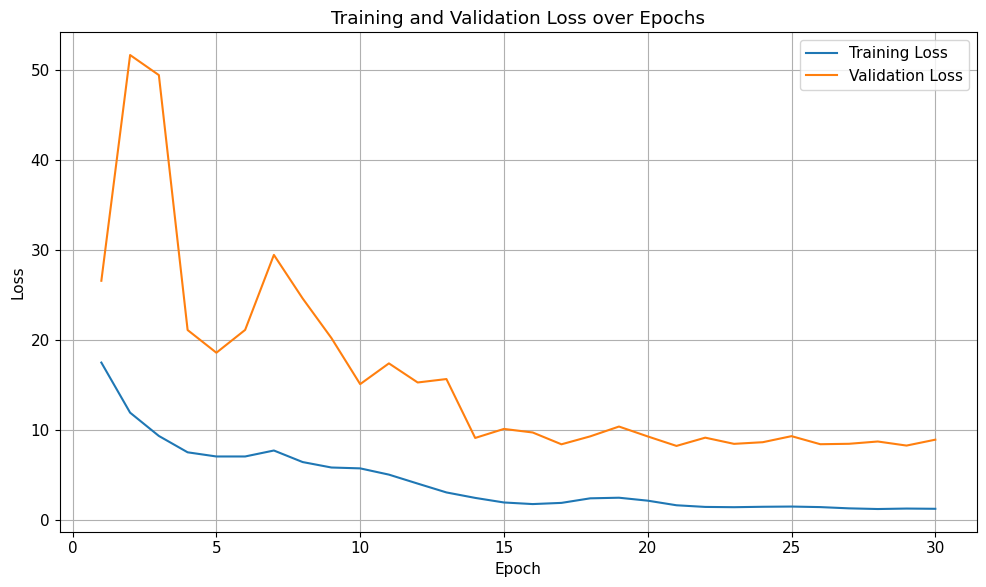

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Testing One Example

In [13]:
import matplotlib.patches as patches

#Always test 0, 101, 1025, 1037, 1049, 998

model.eval()
# Load an image using PIL
image = Image.open('/kaggle/input/dog-and-cat-detection/images/Cats_Test998.png')
orig_w, orig_h = image.size
# Scale factors
scale_x = 224 / orig_w
scale_y = 224 / orig_h

tree = ET.parse('/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1037.xml')  # Change to your XML filename
root = tree.getroot()

print(image.size)
# Define a transformation to convert the image to a tensor and normalize it (optional)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size (e.g., for ResNet)
    transforms.ToTensor(),          # Convert image to tensor
])

# Apply the transformation to the image
image_tensor = transform(image)

# Add a batch dimension (since models expect a batch of images)
image_tensor = image_tensor.unsqueeze(0)

image_tensor = image_tensor.to('cuda')
image_tensor = image_tensor.float()  # uint8 to fp16/32
image_tensor /= 255  # 0 - 255 to 0.0 - 1.0
outputs = model(image_tensor)

all_boxes = []

for feature_map in outputs[1]:
    batch_size, num_anchors, grid_h, grid_w, num_attrs = feature_map.shape
    feature_map = feature_map[0]  # remove batch dimension: [3, 28, 28, 7]

    # Create grid offsets
    # grid_y, grid_x = torch.meshgrid(torch.arange(grid_h), torch.arange(grid_w), indexing="ij")
    grid_y, grid_x = torch.meshgrid(
    torch.arange(grid_h, device=device),
    torch.arange(grid_w, device=device),
    indexing="ij"
    )
    grid_x = grid_x.unsqueeze(0).expand(num_anchors, -1, -1)  # [3, 28, 28]
    grid_y = grid_y.unsqueeze(0).expand(num_anchors, -1, -1)

    # Sigmoid x, y, objectness, class probs (standard YOLO)
    x = torch.sigmoid(feature_map[..., 0]) + grid_x  # [3, 28, 28]
    y = torch.sigmoid(feature_map[..., 1]) + grid_y
    w = torch.exp(feature_map[..., 2])
    h = torch.exp(feature_map[..., 3])
    obj_score = torch.sigmoid(feature_map[..., 4])
    class_probs = torch.softmax(feature_map[..., 5:], dim=-1)

    # Normalize by grid size
    x /= grid_w
    y /= grid_h
    w /= grid_w
    h /= grid_h

    # Combine and reshape to flat list of boxes
    boxes = torch.stack([x, y, w, h, obj_score], dim=-1)  # [3, 28, 28, 5]
    boxes = boxes.reshape(-1, 5)  # [3 * 28 * 28, 5]
    classes = class_probs.reshape(-1, class_probs.shape[-1])  # [3 * 28 * 28, num_classes]

    all_boxes.append((boxes, classes))

(375, 500)


In [14]:
filtered_boxes = []
confidence_threshold = 0.01

for boxes, class_probs in all_boxes:
    obj_scores = boxes[:, 4]
    mask = obj_scores > confidence_threshold
    boxes = boxes[mask]
    class_probs = class_probs[mask]
    obj_scores = obj_scores[mask]
    class_ids = torch.argmax(class_probs, dim=-1)

    for i in range(len(boxes)):
        filtered_boxes.append({
            'box': boxes[i][:4],  # x_center, y_center, w, h
            'score': obj_scores[i].item(),
            'class': class_ids[i].item()
        })

In [15]:
# Prepare tensors for NMS
boxes_xyxy = []
scores = []
class_ids = []
img_w, img_h = 224, 224
for item in filtered_boxes:
    
    xc, yc, w, h = item['box']
    x1 = (xc - w / 2) * img_w
    y1 = (yc - h / 2) * img_h
    x2 = (xc + w / 2) * img_w
    y2 = (yc + h / 2) * img_h
    boxes_xyxy.append([x1, y1, x2, y2])
    scores.append(item['score'])
    class_ids.append(item['class'])

In [16]:
from torchvision.ops import nms
boxes_tensor = torch.tensor(boxes_xyxy)
scores_tensor = torch.tensor(scores)
class_ids_tensor = torch.tensor(class_ids)

# You can apply NMS per class (YOLO-style) or all at once
nms_thresh = 0.6
keep_indices = nms(boxes_tensor, scores_tensor, nms_thresh )

# Keep only boxes after NMS
nms_boxes = boxes_tensor[keep_indices]
nms_scores = scores_tensor[keep_indices]
nms_classes = class_ids_tensor[keep_indices]

# Keep only the box with the highest score
best_idx = torch.argmax(nms_scores)
nms_boxes = [nms_boxes[best_idx]]
nms_scores = [nms_scores[best_idx]]
nms_classes = [nms_classes[best_idx]]



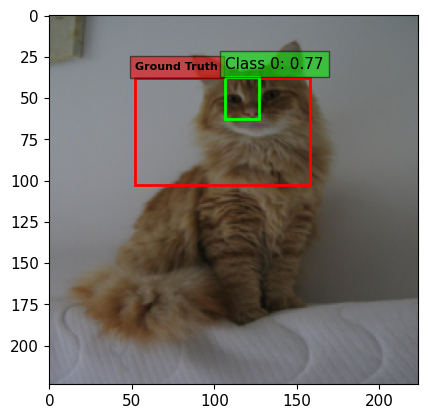

In [17]:
fig, ax = plt.subplots()
ax.imshow(255*image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())

# Extract bounding box
bndbox = root.find('.//bndbox')
xmin = int(bndbox.find('xmin').text)
ymin = int(bndbox.find('ymin').text)
xmax = int(bndbox.find('xmax').text)
ymax = int(bndbox.find('ymax').text)

# Scale factors
scale_x = 224 / orig_w
scale_y = 224 / orig_h

# Scale bounding box
xmin= int(xmin * scale_x)
ymin = int(ymin * scale_y)
xmax = int(xmax * scale_x)
ymax = int(ymax * scale_y)

# Compute box width and height
box_w = xmax - xmin
box_h = ymax - ymin

rect = patches.Rectangle((xmin, ymin), box_w, box_h,
                         linewidth=2, edgecolor='red', facecolor='none')
ax.text(xmin, ymin - 5, "Ground Truth", color='black', fontsize=8,
        weight='bold', bbox=dict(facecolor='red', alpha=0.5))
ax.add_patch(rect)

for i in range(len(nms_boxes)):
# for i in range(20):
    
    x1, y1, x2, y2 = nms_boxes[i]
    score = nms_scores[i].item()
    class_id = nms_classes[i].item()

    box_w = x2 - x1
    box_h = y2 - y1

    rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f'Class {class_id}: {score:.2f}', color='black',
            bbox=dict(facecolor='lime', alpha=0.5))

# Model Validation

In [18]:
from RAD_assignment.utils.metrics import ConfusionMatrix, ap_per_class, box_iou
from RAD_assignment.utils.plots import output_to_target, plot_images, plot_val_study
from RAD_assignment.utils.general import scale_boxes, non_max_suppression, xywh2xyxy, LOGGER
from RAD_assignment.val import process_batch, save_one_txt
from pathlib import Path
import numpy as np
%matplotlib inline


def validate(model, data_loader):
    global criterion
    batch_size=4  # batch size
    imgsz=224 # inference size (pixels)
    conf_thres=0.001  # confidence threshold
    iou_thres=0.6 # NMS IoU threshold
    compute_loss = True
    conf_thres=0.001
    plots= True
    single_cls=False 
    save_dir ='/'
    save_txt = True
    save_conf= False
    # Configure
    model.eval()
    cuda = device.type != "cpu"
    
    nc = 2 
    iouv = torch.linspace(0.5, 0.95, 10, device="cpu")  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()
    names = model.names
    if isinstance(names, (list, tuple)):  # old format
        names = dict(enumerate(names))
    seen = 0
    confusion_matrix = ConfusionMatrix(nc=nc)
    class_map = list(range(2))
    s = ("%22s" + "%11s" * 6) % ("Class", "Images", "Instances", "P", "R", "mAP50", "mAP50-95")
    tp, fp, p, r, f1, mp, mr, map50, ap50, map = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    loss = torch.zeros(3, device=device)
    mean_center_align = 0  # Initialize mean center alignment
    aspect_ratio_diff = 0  # Initialize aspect ratio difference
    count = 0  # Initialize count for averaging the metrics
    jdict, stats, ap, ap_class = [], [], [], []
    pbar = tqdm(data_loader, desc=s)  # progress bar
    for batch_i, (im, targets, paths, shapes) in enumerate(pbar):
        if cuda:
            im = im.to(device, non_blocking=True)
            targets = targets.to(device)
        im = im.float()  # uint8 to fp16/32
        im /= 255  # 0 - 255 to 0.0 - 1.0
        nb, _, height, width = im.shape  # batch size, channels, height, width

        preds, train_out = model(im) 
        
        # # Loss
        # if compute_loss:
        #     loss += criterion(train_out, targets)[1]  # box, obj, cls

        # NMS
        targets[:, 2:] *= torch.tensor((width, height, width, height), device=device)  # to pixels
        max_det = 1
        
        preds = non_max_suppression(
            preds, conf_thres=conf_thres, iou_thres=iou_thres, multi_label=True, agnostic=False, max_det=max_det
        )
        

        # Metrics
        for si, pred in enumerate(preds):
            labels = targets[targets[:, 0] == si, 1:]
            nl, npr = labels.shape[0], pred.shape[0]  # number of labels, predictions
            count += npr 
            path, shape = Path(paths[si]), shapes[si]
            correct = torch.zeros(npr, niou, dtype=torch.bool, device=device)  # init
            seen += 1

            if npr == 0:
                if nl:
                    stats.append((correct, *torch.zeros((2, 0), device=device), labels[:, 0]))
                    if plots:
                        confusion_matrix.process_batch(detections=None, labels=labels[:, 0])
                continue

            # Predictions
            if single_cls:
                pred[:, 5] = 0
            predn = pred.clone()
            predn = predn.to("cpu").detach()
            scale_boxes(im[si].shape[1:], predn[:, :4], shape)  # native-space pred

            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                tbox = tbox.to("cpu").detach()
                labels = labels.to("cpu").detach()
                scale_boxes(im[si].shape[1:], tbox, shape)  # native-space labels
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                labelsn = labelsn.to("cpu").detach()
                correct = process_batch(predn, labelsn, iouv)

                # Mean center alignment
                pred_centers = (predn[:, :2] + predn[:, 2:4]) / 2  # (xmin + xmax) / 2, (ymin + ymax) / 2
                true_centers = (tbox[:, :2] + tbox[:, 2:4]) / 2  # (xmin + xmax) / 2, (ymin + ymax) / 2
                center_distance = torch.sqrt(torch.sum((pred_centers - true_centers) ** 2, dim=1))
                mean_center_align += center_distance.mean().item()  # Calculate mean center alignment
                
                # Aspect ratio difference
                pred_ar = (predn[:, 2] - predn[:, 0]) / (predn[:, 3] - predn[:, 1])  # width / height
                true_ar = (tbox[:, 2] - tbox[:, 0]) / (tbox[:, 3] - tbox[:, 1])  # width / height
                ar_diff = torch.abs(pred_ar - true_ar)
                aspect_ratio_diff += ar_diff.mean().item()  # Calculate mean aspect ratio difference
                
                if plots:
                    confusion_matrix.process_batch(predn, labelsn)
            stats.append((correct, pred[:, 4], pred[:, 5], labels[:, 0]))  # (correct, conf, pcls, tcls)

            # Save/log
            if save_txt:
                (Path(save_dir) / "labels").mkdir(parents=True, exist_ok=True)
                save_one_txt(predn, save_conf, shape, file=Path(save_dir) / "labels" / f"{path.stem}.txt")

        # # Plot images
        # if plots and batch_i < 3:
        #     plot_images(im, targets, paths, Path(save_dir) / f"val_batch{batch_i}_labels.jpg", names)  # labels
        #     plot_images(im.to("cpu").detach(), output_to_target(preds).to("cpu").detach(), paths, Path(save_dir) / f"val_batch{batch_i}_pred.jpg", names)  # pred

    # print(loss)
    # Compute metrics
    stats = [torch.cat(x, 0).cpu().detach().numpy() for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=plots, save_dir=Path(save_dir), names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    else:
        print("empty")
    nt = np.bincount(stats[3].astype(int), minlength=nc)  # number of targets per class
    pf = "%22s" + "%11i" * 2 + "%11.3g" * 4  # print format
    LOGGER.info(pf % ("all", seen, nt.sum(), mp, mr, map50, map))
    for i, c in enumerate(ap_class):
            LOGGER.info(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
    # Log mean center alignment and aspect ratio difference
    LOGGER.info(f"Mean Center Alignment: {mean_center_align / count}")
    LOGGER.info(f"Aspect Ratio Difference: {aspect_ratio_diff / count}")

                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]
                   all         40         40      0.618      0.361      0.436      0.163
                     0         40         18        0.8      0.222      0.489      0.186
                     1         40         22      0.437        0.5      0.383      0.139
Mean Center Alignment: 23.4875979244709
Aspect Ratio Difference: 0.22883527651429175


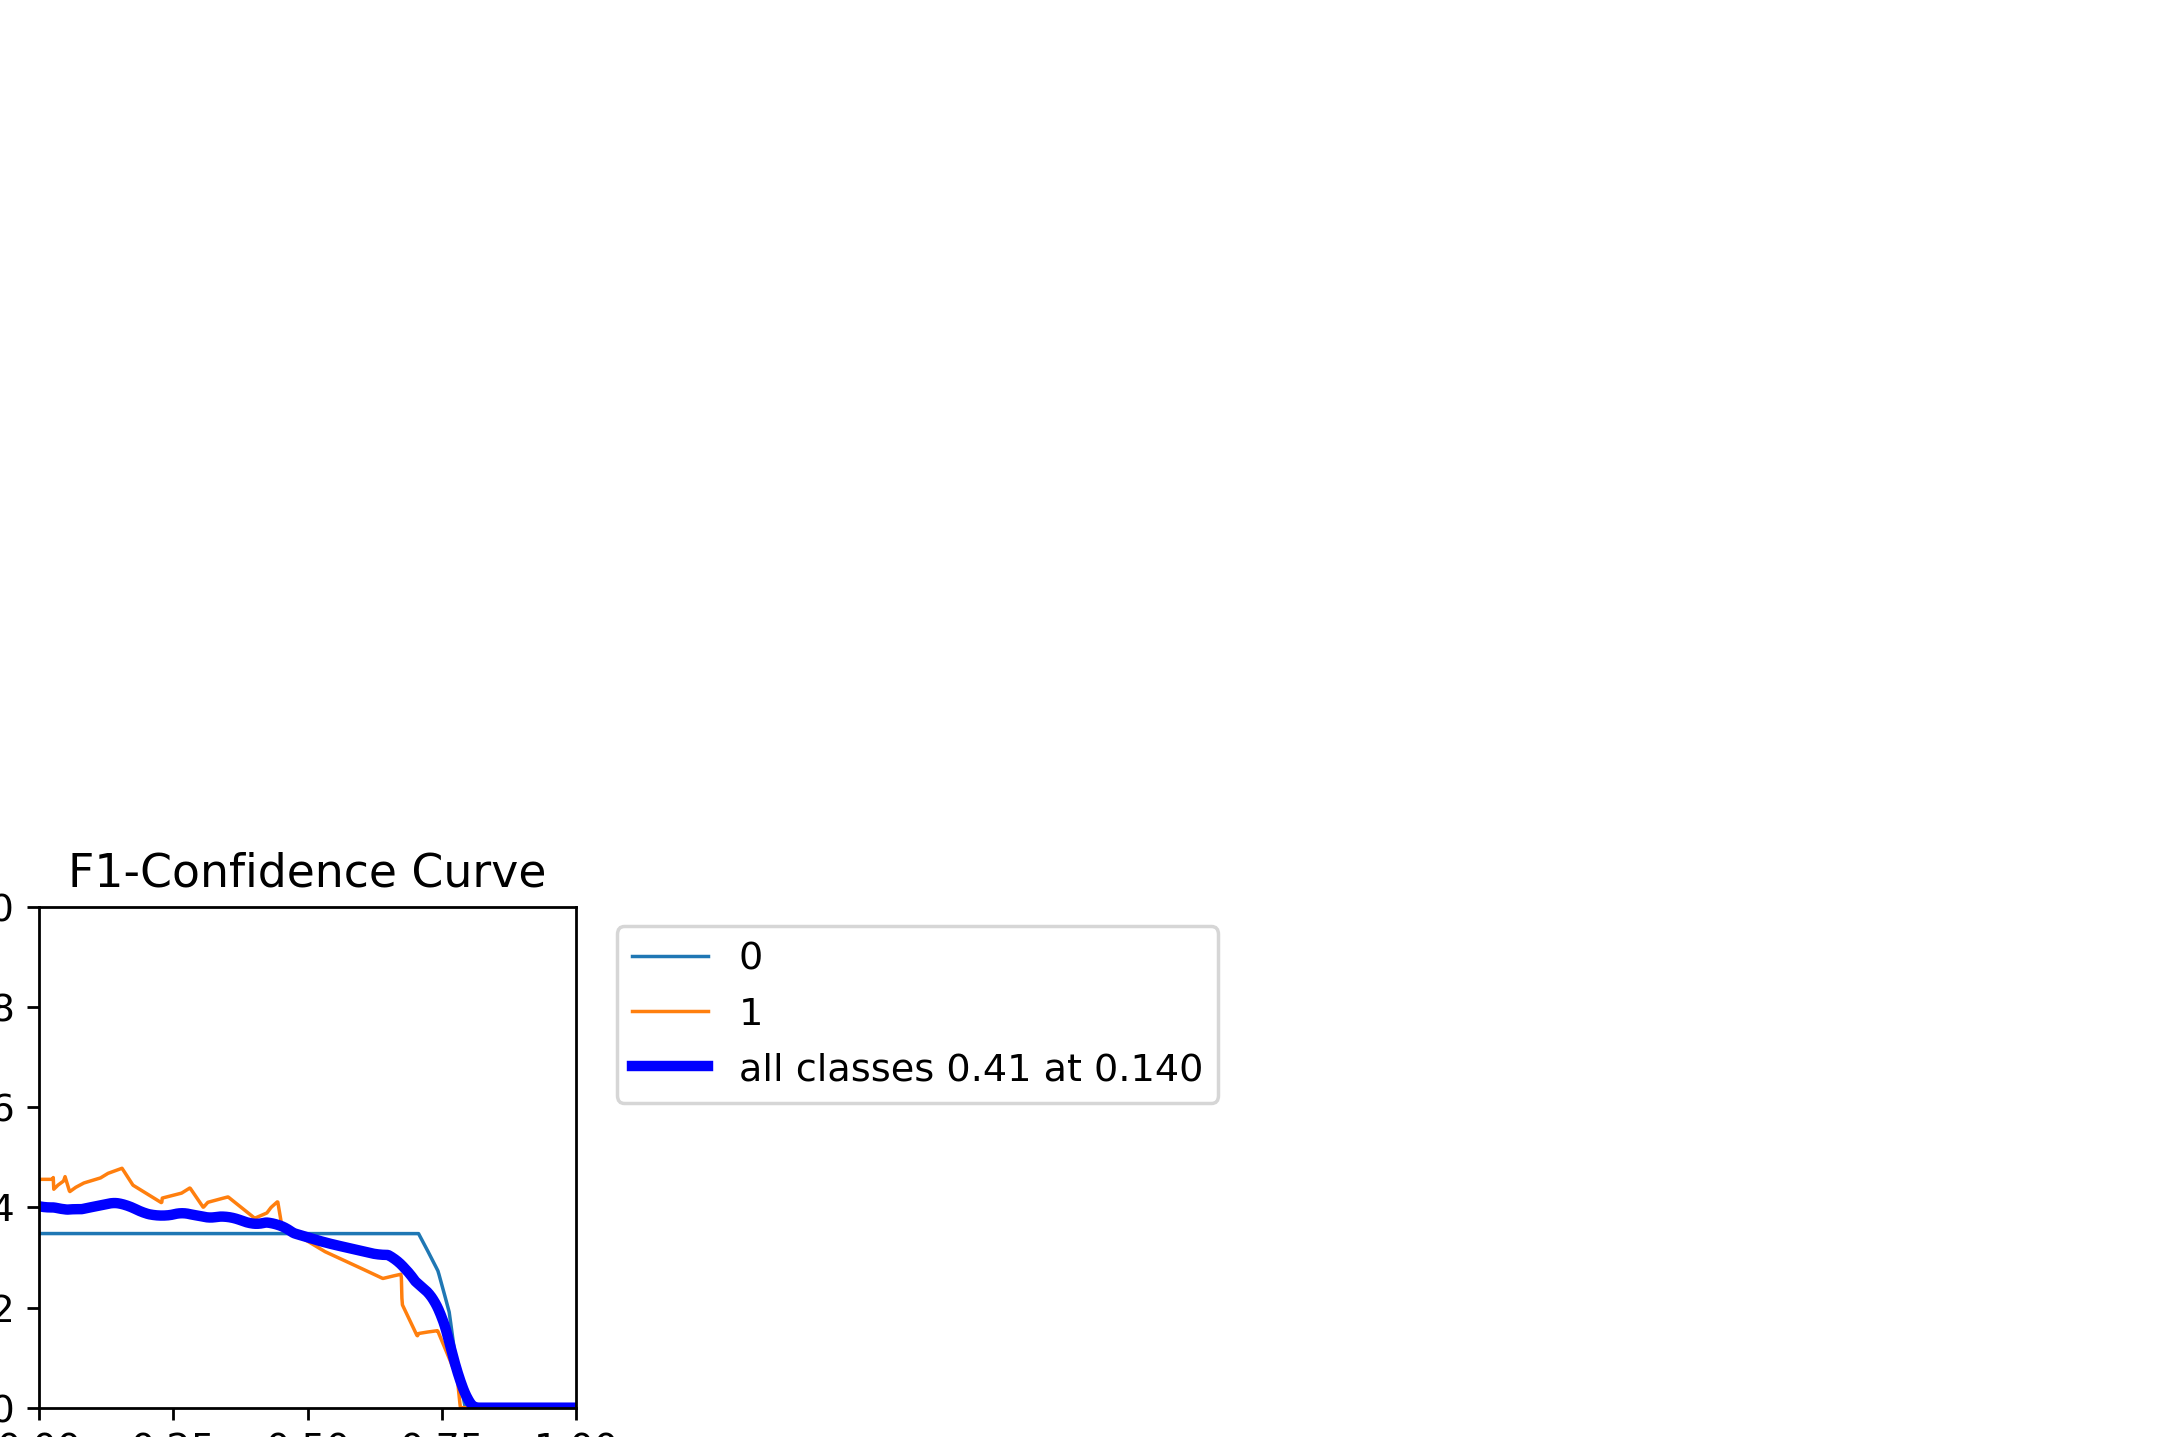

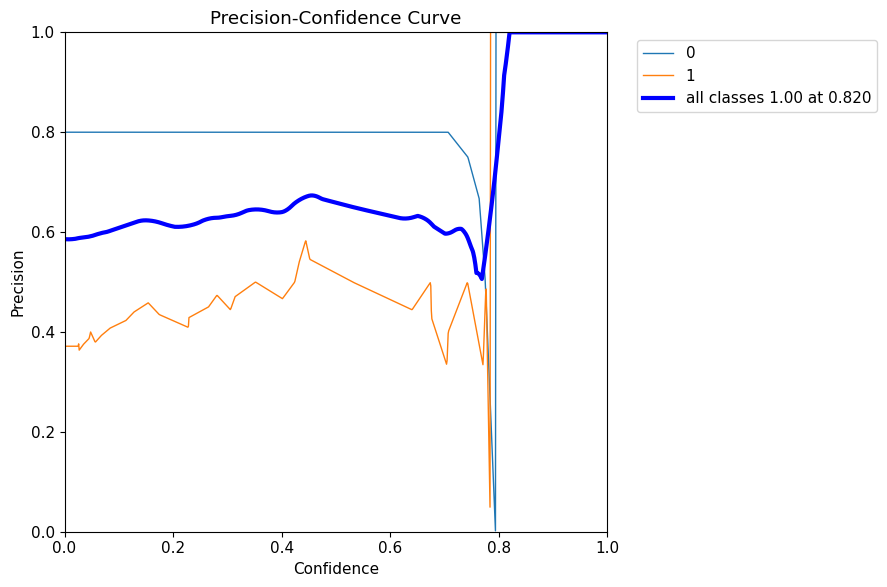

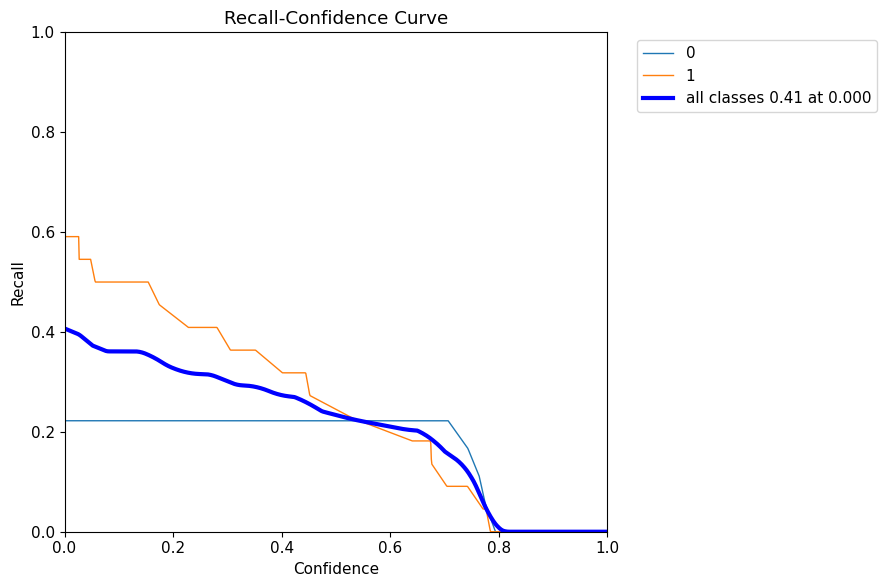

In [19]:
model.eval()
validate(model, val_loader)